**<font color = black size=6>实验十一：支持向量机</font>**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cvxopt
from cvxopt import matrix
from cvxopt import solvers

**<font color = blue size=4>第一部分:函数介绍</font>**

二次规划问题是形式如下的一类最优化问题：
$$
\begin{align}
\min_x \quad  &\frac{1}{2}x^TPx+q^Tx \\
s.t. \quad  &Gx\leq h \\
      &Ax=b
\end{align}
$$
对于这一类问题可以使用[cvxopt](https://cvxopt.org/userguide/coneprog.html#quadratic-programming)库的solvers.qp()函数进行求解。

以下是一个例子（参考[Solving a quadratic program](https://cvxopt.org/examples/tutorial/qp.html)）:
$$
\begin{align}
\min_x \quad  &2x_1^2+x_2^2+x_1x_2+x_1+x_2 \\
s.t. \quad  &x_1\geq 0 \\
      &x_2\geq 0 \\
      &x_1+x_2=1
\end{align}
$$
为了使用solvers.qp()函数，我们需要知道在该二次规划问题中的$P,q,G,h,A,b$矩阵分别是什么。
在该优化问题中，

* $P:=\begin{bmatrix}
    4 & 1 \\ 1 & 2
   \end{bmatrix}$,
* $q:=\begin{bmatrix}
    1 \\ 1
   \end{bmatrix}$,
* $G:=\begin{bmatrix}
    -1 & 0 \\ 0 & -1
   \end{bmatrix}$,
* $h:=\begin{bmatrix}
    0 \\ 0
   \end{bmatrix}$,
* $A:=\begin{bmatrix}
    1 & 1
   \end{bmatrix}$,
* $b:=\begin{bmatrix}
    1
   \end{bmatrix}$,
   
把这些参数送入solvers.qp()函数中即可求出解。

In [2]:
# Tips1: cvxopt库中的matrix只接受double类型的数据
# Tips2: matrix使用列表作为参数创建矩阵和numpy.array使用列表作为参数创建矩阵是不同的
# print(matrix([[1.0, 1.0]]))
# print(np.array([[1.0, 1.0]]))
# print(matrix(np.array([[1.0, 1.0]])))
Q = 2*matrix([ [2, .5], [.5, 1] ])
p = matrix([1.0,1.0])
G = matrix([[-1.0,0.0],[0.0,-1.0]])
h = matrix([0.0,0.0])
A = matrix([1.0, 1.0], (1,2))
b = matrix(1.0)
sol=solvers.qp(Q, p, G, h, A, b)
print(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  1.8889e+00  7.7778e-01  1e+00  3e-16  2e+00
 1:  1.8769e+00  1.8320e+00  4e-02  1e-16  6e-02
 2:  1.8750e+00  1.8739e+00  1e-03  2e-16  5e-04
 3:  1.8750e+00  1.8750e+00  1e-05  1e-16  5e-06
 4:  1.8750e+00  1.8750e+00  1e-07  3e-16  5e-08
Optimal solution found.
[ 2.50e-01]
[ 7.50e-01]



**<font color = blue size=4>第二部分:实验任务</font>**

1.线性可分支持向量机与硬间隔最大化

<span style="color:purple">1)  
这一部分使用的数据集'dataset1.csv'是一个线性可分的数据集。每个数据样本包含两个特征$x_1$, $x_2$以及一个标签$y\in\{1,-1\}$。  
首先，请读入数据集'dataset1.csv',把数据类型都转换成np.double类型，并画出数据集的散点图，给正样本（y为+1）和负样本（y为-1）分别标上不同的颜色。</span>

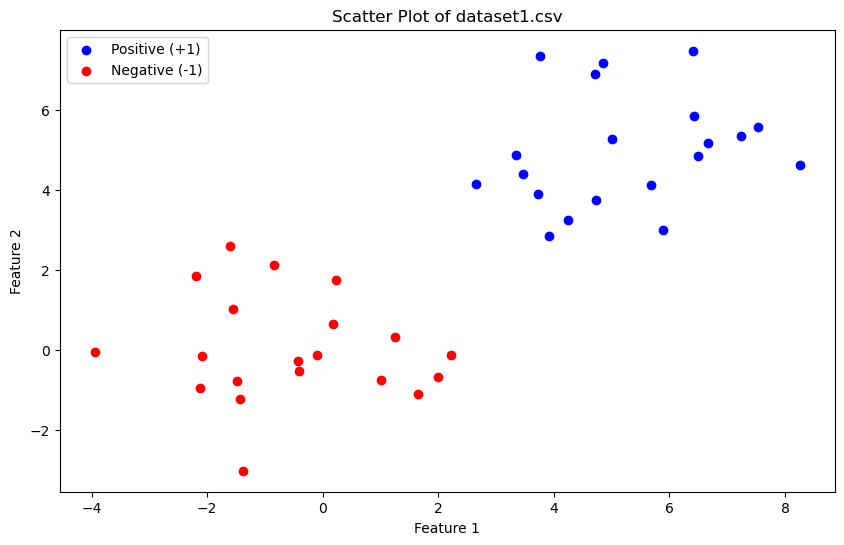

In [3]:
# ---- Your code here ----

# 读入数据集
dataset1 = pd.read_csv("dataset1.csv")
# 将数据类型都转换成np.double类型的numpy数组
dataset1 = np.array(dataset1, dtype="double")
# 将数据集按照标签进行划分 即正样本和负样本
positive_samples = dataset1[dataset1[:, -1] == 1]
negative_samples = dataset1[dataset1[:, -1] == -1]

plt.figure(figsize=(10, 6))
# 绘制正样本点
plt.scatter(positive_samples[:, 0], positive_samples[:, 1], color="blue", label="Positive (+1)")
# 绘制负样本点
plt.scatter(negative_samples[:, 0], negative_samples[:, 1], color="red", label="Negative (-1)")

# 图注相关
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of dataset1.csv")
plt.legend()
plt.show()

<span style="color:purple">2)  
求对偶问题的最优解$\lambda^*$  
在数据线性可分的场景中，为了找到一个能最好地划分正样本和负样本的超平面$\pmb{\omega}^T \pmb{x}+b=0$，我们需要求解下面这个主问题。
\begin{align}
\min_{\pmb{\omega},b}\quad &\frac12 ||\pmb{\omega}||^2\\
s.t.\quad &y_i(\pmb{\omega}^T \pmb{x}_i+b)\ge 1,i=1,...,m
\end{align}
</span>

<span style="color:purple">对应地，即求解如下对偶问题（参考课件）：</span>
$$
\begin{align}
\min_\lambda \quad  &\frac{1}{2}\sum_{i=1}^m\sum_{j=1}^m\lambda_i\lambda_jy_iy_j\pmb{x}_i^T\pmb{x}_j-\sum_{i=1}^m\lambda_i \\
s.t. \quad  &\sum_{i=1}^m\lambda_iy_i=0 \\
      &\pmb{\lambda}\geq \pmb{0}
\end{align}
$$

这个优化问题是一个二次规划问题，可以写成如下形式：
$$
\begin{align}
\min_{\pmb{\lambda}} \quad  &\frac{1}{2}\lambda^TP\lambda+q^T\lambda \\
s.t. \quad  &G\lambda\leq h \\
      &A\lambda=b
\end{align}
$$

* $P是一个m\times m的矩阵，其中P_{ij}=y_iy_j\pmb{x}_i^T\pmb{x}_j$,
* $q是一个m\times 1的所有值都为-1的列向量，即q:=\begin{bmatrix}
    -1 & -1 & \cdots & -1
   \end{bmatrix}^T$,
* $G:=\begin{bmatrix}
    -1 & 0 & \cdots & 0 \\
    0 & -1 & \cdots & 0 \\
   \vdots & \vdots & \ddots &0 \\
   0 & 0 & 0 & -1
   \end{bmatrix}_{m\times m}=-\pmb{I},\pmb{I}为单位矩阵,$
* $h是一个m\times 1的零向量,即h:=\begin{bmatrix}
    0 & 0 & \cdots & 0
   \end{bmatrix}^T$,
* $A:=\begin{bmatrix}
    y_1 & y_2 & \cdots & y_m
   \end{bmatrix}^T$,
* $b:=\begin{bmatrix}
    0
   \end{bmatrix},一个标量$
   
把上述参数送入求解器solvers.qp()中即可得到最优解$\lambda^*$。 
 
附：$P$矩阵的一个计算方法：
设$X=\begin{bmatrix}
    x_{11} & x_{12} \\
    x_{21} & x_{22} \\
    \vdots & \vdots \\
    x_{m1} & x_{m2}
   \end{bmatrix}$,
   $Y=\begin{bmatrix}
    y_{1} \\
    y_{2} \\
    \vdots \\
    y_{m}
   \end{bmatrix}$,
   
计算$X'=\begin{bmatrix}
    x_{11}y_1 & x_{12}y_1 \\
    x_{21}y_2 & x_{22}y_2 \\
    \vdots & \vdots \\
    x_{m1}y_m & x_{m2}y_m
   \end{bmatrix}=X*Y(注意这里是星乘)$
   
则$P=X'X'^T$。

In [4]:
# ---- Your code here ----
# 如果求解报错可以尝试在solvers.qp()中添加参数kktsolver='ldl'

m, n = dataset1.shape

# 从数据集中获取属性列和标签列
X = dataset1[:, :-1]  # 属性值
Y = dataset1[:, -1].reshape(-1, 1)  # 标签
# 初始化P矩阵
P = np.zeros((m, m))
# 根据矩阵P的计算方法 计算P矩阵
X_ = X * Y
P = matrix(X_ @ X_.T)
# print(P)

# 另一个计算矩阵P的方法
# for i in range(m):
#     for j in range(m):
#         P[i, j] = Y[i] * Y[j] * np.dot(X[i], X[j])  # 根据P_ij进行求解
# P = matrix(P)

# q是一个m x 1的所有值都为-1的列向量
q = matrix(-1.0, (m, 1))
# print(q)

# G为-1单位矩阵
G = np.eye(m) * -1  # 构造m x m的-1单位矩阵
G = matrix(G)
# print(G)

# h是m x 1的所有值都为0的列向量
h = matrix(0.0, (m, 1))
# print(h)

# A是标签列 需要转换成行形式
# print(matrix(dataset1[:, -1]))
A = matrix(dataset1[:, -1]).T
# print(A)

# b=[0] 标量
b = matrix(0.0)
# print(b)

# 送入函数中进行求解
sol = solvers.qp(P, q, G, h, A, b, kktsolver="ldl")
# 得到对偶问题的解lambda_star
lambda_star = sol["x"]
print()
print("Hard Margin")
print("对偶问题的解lambda_star:")
print(lambda_star)
# print(type(lambda_star))

     pcost       dcost       gap    pres   dres
 0: -5.2553e+00 -9.0147e+00  1e+02  1e+01  2e+00
 1: -4.9265e+00 -1.9551e+00  2e+01  2e+00  3e-01
 2: -1.5759e-01 -3.1831e-01  7e-01  4e-02  7e-03
 3: -1.3147e-01 -1.9706e-01  7e-02  1e-16  1e-15
 4: -1.7378e-01 -1.8099e-01  7e-03  8e-17  6e-16
 5: -1.7979e-01 -1.8010e-01  3e-04  4e-17  8e-16
 6: -1.8003e-01 -1.8003e-01  3e-06  4e-17  8e-16
 7: -1.8003e-01 -1.8003e-01  3e-08  6e-17  8e-16
Optimal solution found.

Hard Margin
对偶问题的解lambda_star:
[ 1.61e-09]
[ 5.12e-02]
[ 2.56e-10]
[ 1.03e-09]
[ 2.50e-10]
[ 4.43e-10]
[ 1.16e-09]
[ 2.18e-10]
[ 2.61e-10]
[ 2.92e-10]
[ 3.87e-10]
[ 6.08e-09]
[ 1.37e-09]
[ 3.58e-10]
[ 4.21e-10]
[ 4.86e-10]
[ 3.68e-10]
[ 1.29e-01]
[ 2.97e-10]
[ 4.50e-10]
[ 6.52e-10]
[ 3.53e-09]
[ 4.81e-10]
[ 1.58e-09]
[ 3.51e-10]
[ 1.80e-01]
[ 3.07e-10]
[ 5.06e-10]
[ 8.12e-10]
[ 3.97e-10]
[ 2.12e-08]
[ 2.07e-10]
[ 2.33e-10]
[ 2.26e-09]
[ 3.96e-10]
[ 6.20e-10]
[ 4.16e-10]
[ 7.28e-10]
[ 4.78e-10]
[ 3.15e-10]



<span style="color:purple">3)  
求出$\pmb{\omega}^*=\sum_{i=1}^m\lambda_i^*y_i\pmb{x}_i$和$b^*=y_j-\pmb{\omega}^{*T}\pmb{x_j}$, 其中$j$为$\lambda^*$中的一个正分量$\lambda_j^*>0$的下标。  
注意：由于求解器求出来的是一个近似解，所以$\lambda^*$中很多实际上为0的分量会略大于0，这时候可以设置一个阈值把非常靠近0的那些分量筛去，再从剩下的分量中选取一个正分量来计算$b^*$,或者也可以直接取$\lambda^*$中最大的分量来计算$b^*$。</span>

In [5]:
# ---- Your code here ----

m, n = dataset1.shape
# 计算w_star
X = dataset1[:, :-1]  # 属性值xi
Y = dataset1[:, -1].reshape(-1, 1)  # 标签yi
lambda_star = np.array(lambda_star)  # 从矩阵转换成numpy数组
w_star = np.sum(lambda_star * Y * X, axis=0)  # axis=0 保证是对每个特征维度进行求和

# 设置阈值对lambda_star进行筛选和最大值的获取
threshold = 1e-8  # 阈值
max_lambda_star = 0  # 初始化最大分量进行比较
max_index = None  # 初始化最大分量的索引
for i in range(m):
    if lambda_star[i] < threshold:
        # 避免选取靠近0的分量
        # 同时进行筛选 便于后续支持向量的选取
        lambda_star[i] = 0
    elif lambda_star[i] > max_lambda_star:
        # 获取lambda_star中最大分量对应的索引
        max_lambda_star = lambda_star[i]
        max_index = i

# 取lambda_star中最大的分量来计算b_star
j = max_index
# 计算b_star
b_star = Y[j] - w_star @ X[j]
b_star = b_star[0]  # 标量
# 输出结果
print("w_star:", w_star)
print("b_star:", b_star)

w_star: [0.40821121 0.43979838]
b_star: -1.855681983818327


<span style="color:purple">4)  
画出数据集的散点图，给正样本（y为+1）和负样本（y为-1）分别标上不同的颜色，再为支持向量（训练数据中$\lambda_j^*>0$的对应的样本）标上不同的颜色，并画出决策边界$\pmb{\omega}^{*T}\pmb{x}+b=0$和间隔边界$\pmb{\omega}^{*T}\pmb{x}+b=1$与$\pmb{\omega}^{*T}\pmb{x}+b=-1$。</span>

Hard Margin Support Vectors: num:4
[[ 0.22177922  1.73977249]
 [ 2.22480156 -0.11938869]
 [ 3.92239715  2.85247871]
 [ 2.65759955  4.13140472]]


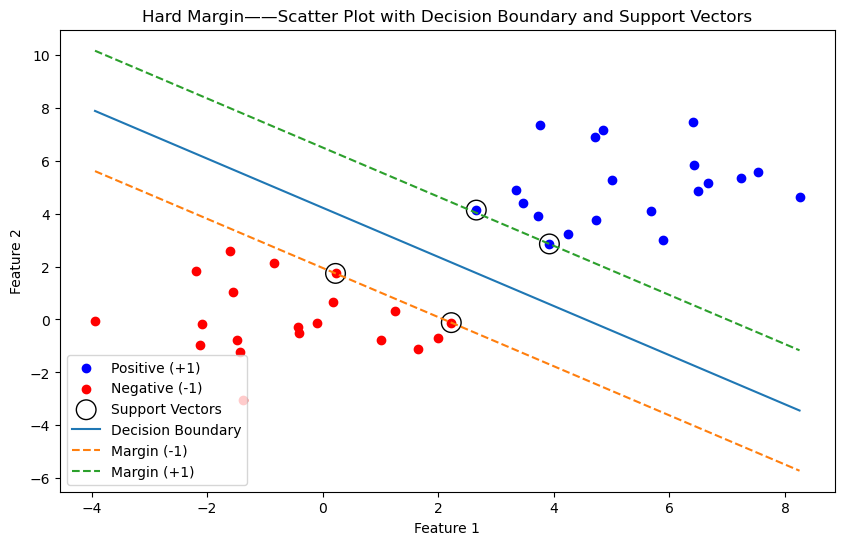

In [6]:
# ---- Your code here ----

# 将数据集按照标签进行划分 即正样本和负样本
positive_samples = dataset1[dataset1[:, -1] == 1]
negative_samples = dataset1[dataset1[:, -1] == -1]
X = dataset1[:, :-1]  # 属性值

plt.figure(figsize=(10, 6))
# 绘制正样本点
plt.scatter(positive_samples[:, 0], positive_samples[:, 1], color="blue", label="Positive (+1)")
# 绘制负样本点
plt.scatter(negative_samples[:, 0], negative_samples[:, 1], color="red", label="Negative (-1)")

# 识别支持向量
support_vectors_indices = np.where(lambda_star > 0)[0]  # 提取行索引
support_vectors = X[support_vectors_indices]
print("Hard Margin Support Vectors: num:{}".format(len(support_vectors)))
print(support_vectors)
# 标记支持向量
plt.scatter(
    support_vectors[:, 0],
    support_vectors[:, 1],
    s=200,
    facecolors="none",
    edgecolors="k",
    label="Support Vectors",
)

# 创建用于绘制边界的 x 范围
x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)

# 绘制决策边界
y1 = (-b_star - w_star[0] * x_range) / w_star[1]
# 绘制间隔边界
y2 = (-1 - b_star - w_star[0] * x_range) / w_star[1]
y3 = (1 - b_star - w_star[0] * x_range) / w_star[1]
plt.plot(x_range, y1, label="Decision Boundary")
plt.plot(x_range, y2, "--", label="Margin (-1)")
plt.plot(x_range, y3, "--", label="Margin (+1)")

# 添加标注和图例
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Hard Margin——Scatter Plot with Decision Boundary and Support Vectors")
plt.legend()
plt.show()

2.线性支持向量机与软间隔最大化

<span style="color:purple">1)  
这一部分使用的数据集'dataset2.csv'是一个数据近似线性可分的数据集。每个数据样本同样包含两个特征$x_1$, $x_2$以及一个标签$y\in\{1,-1\}$。   
读入数据集'dataset2.csv',把数据类型都转换成np.double类型，并画出数据集的散点图，给正样本（y为+1）和负样本（y为-1）分别标上不同的颜色。</span>

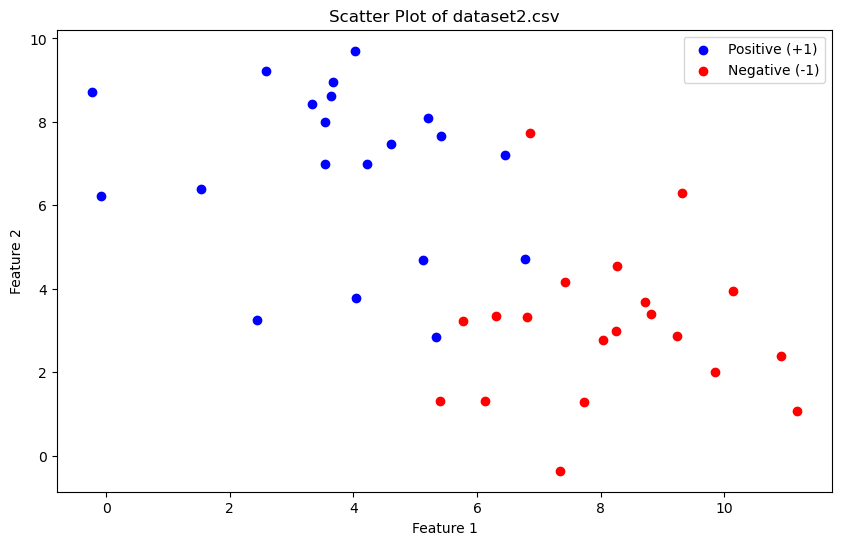

In [7]:
# ---- Your code here ----

# 读入数据集
dataset2 = pd.read_csv("dataset2.csv")
# 将数据类型都转换成np.double类型的numpy数组
dataset2 = np.array(dataset2, dtype="double")
# 将数据集按照标签进行划分 即正样本和负样本
positive_samples = dataset2[dataset2[:, -1] == 1]
negative_samples = dataset2[dataset2[:, -1] == -1]

plt.figure(figsize=(10, 6))
# 绘制正样本点
plt.scatter(positive_samples[:, 0], positive_samples[:, 1], color="blue", label="Positive (+1)")
# 绘制负样本点
plt.scatter(negative_samples[:, 0], negative_samples[:, 1], color="red", label="Negative (-1)")

# 图注相关
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of dataset2.csv")
plt.legend()
plt.show()

<span style="color:purple">2)  
求对偶问题的最优解$\lambda^*$  
在数据近似线性可分的场景中，为了找到一个能最好地划分正样本和负样本的超平面$\pmb{\omega}^T \pmb{x}+b=0$，我们需要求解下面这个主问题。
\begin{align}
\min_{\pmb{\omega},b,\xi_i}\quad &\frac12 ||\pmb{\omega}||^2+C\times\sum_{i=1}^m \xi_i\\
s.t.\quad &y_i(\pmb{\omega}^T \pmb{x}_i+b)\ge 1-\xi_i,i=1,...,m\\
&\xi_i\ge 0, i=1,...,m\\
\end{align}
</span>

<span style="color:purple">对应地，我们需要选择一个参数C，求解如下对偶问题（参考课件）：</span>
$$
\begin{align}
\min_\lambda \quad  &\frac{1}{2}\sum_{i=1}^m\sum_{j=1}^m\lambda_i\lambda_jy_iy_j\pmb{x}_i^T\pmb{x}_j-\sum_{i=1}^m\lambda_i \\
s.t. \quad  &\sum_{i=1}^m\lambda_iy_i=0 \\
      &\pmb{0}\leq \pmb{\lambda}\leq C 
\end{align}
$$

同样地，这个问题也可以写成如下形式：  
$$
\begin{align}
\min_{\lambda} \quad  &\frac{1}{2}\lambda^TP\lambda+q^T\lambda \\
s.t. \quad  &G\lambda\leq h \\
      &A\lambda=b
\end{align}
$$


* $G:=\begin{bmatrix}
    -1 & 0 & \cdots & 0 \\
    0 & -1 & \cdots & 0 \\
   \vdots & \vdots & \ddots &0 \\
   0 & 0 & 0 & -1 \\
   1 & 0 & \cdots & 0 \\
    0 & 1 & \cdots & 0 \\
   \vdots & \vdots & \ddots &0 \\
   0 & 0 & 0 & 1
   \end{bmatrix}_{2m\times m}=\begin{bmatrix}
    -\pmb{I} \\
    \pmb{I}
   \end{bmatrix},\pmb{I}为单位矩阵,$
* $h:=\begin{bmatrix}
    0 \\
    0 \\
    \vdots \\
    0 \\
    C \\
    C \\
    \vdots \\
    C
   \end{bmatrix}_{2m\times 1}, 即一个m\times 1的零列向量与一个m\times 1的分量全为C的列向量上下拼接$,
* $P,q,A,b$与硬间隔优化问题中的矩阵相同。  
* 参数$C$请自行选择。

In [8]:
# ---- Your code here ----

# 选择一个参数C
C = 8
m, n = dataset2.shape

# 从数据集中获取属性列和标签列
X = dataset2[:, :-1]  # 属性值
Y = dataset2[:, -1].reshape(-1, 1)  # 标签
# 初始化P矩阵
P = np.zeros((m, m))
# 根据矩阵P的计算方法 计算P矩阵
X_ = X * Y
P = matrix(X_ @ X_.T)

# 另一个计算矩阵P的方法
# for i in range(m):
#     for j in range(m):
#         P[i, j] = Y[i] * Y[j] * np.dot(X[i], X[j])  # 根据P_ij进行求解
# P = matrix(P)
# print(P)

# q是一个m x 1的所有值都为-1的列向量
q = matrix(-1.0, (m, 1))
# print(q)

# 构建G矩阵
G_top = np.eye(m) * -1.0  # 构造m x m的-1单位矩阵
G_bottom = np.eye(m)  # 构造m x m的单位矩阵
G = np.vstack((G_top, G_bottom))  # 进行上下拼接
G = matrix(G)

# 构建h向量
h_top = np.zeros(m)
h_bottom = np.ones(m) * C
h = np.hstack((h_top, h_bottom))  # 进行拼接
h = matrix(h.reshape(-1, 1))
# print(h)

# A是标签列 需要转换成行形式
# print(matrix(dataset2[:, -1]))
A = matrix(dataset2[:, -1]).T
# print(A)

# b=[0] 标量
b = matrix(0.0)
# print(b)

# 送入函数中进行求解
sol = solvers.qp(P, q, G, h, A, b, kktsolver="ldl")
# 得到对偶问题的解lambda_star
lambda_star = sol["x"]
print()
print("Soft Margin")
print("对偶问题的解lambda_star:")
print(lambda_star)
# print(type(lambda_star))

     pcost       dcost       gap    pres   dres
 0: -5.1311e+01 -1.8328e+03  5e+03  8e-01  3e-13
 1: -3.3274e+01 -5.6333e+02  8e+02  1e-01  2e-13
 2: -2.6319e+01 -1.1965e+02  1e+02  1e-02  2e-13
 3: -3.5971e+01 -6.0963e+01  3e+01  2e-03  2e-13
 4: -4.1030e+01 -4.5094e+01  4e+00  1e-04  2e-13
 5: -4.2185e+01 -4.3742e+01  2e+00  4e-05  2e-13
 6: -4.2933e+01 -4.3102e+01  2e-01  1e-06  2e-13
 7: -4.3005e+01 -4.3006e+01  2e-03  1e-08  2e-13
 8: -4.3005e+01 -4.3005e+01  2e-05  1e-10  2e-13
Optimal solution found.

Soft Margin
对偶问题的解lambda_star:
[ 3.16e-08]
[ 2.33e-07]
[ 2.78e-08]
[ 8.00e+00]
[ 4.36e-08]
[ 2.28e+00]
[ 2.09e-07]
[ 5.84e-08]
[ 7.43e-08]
[ 6.47e-08]
[ 3.65e-07]
[ 1.67e-07]
[ 6.64e-08]
[ 9.07e-08]
[ 4.71e-08]
[ 5.97e+00]
[ 8.14e-08]
[ 3.85e-08]
[ 5.13e-08]
[ 4.64e-08]
[ 1.20e-07]
[ 9.41e-08]
[ 3.70e+00]
[ 8.00e+00]
[ 3.35e-08]
[ 7.35e-08]
[ 2.56e-08]
[ 2.76e-07]
[ 3.32e-08]
[ 2.24e-08]
[ 7.28e-08]
[ 4.55e-08]
[ 4.97e-08]
[ 8.00e+00]
[ 8.72e-08]
[ 8.00e+00]
[ 1.51e-07]
[ 8.11e-08]

<span style="color:purple">3)  
求出$\pmb{\omega}^*=\sum_{i=1}^m\lambda_i^*y_i\pmb{x}_i$和$b^*=y_j-\pmb{\omega}^{*T}\pmb{x_j}$, 其中$j$为$\lambda^*$中的一个正分量$0<\lambda_j^*<C$的下标。与硬间隔优化问题同理，应该避免选择非常接近0和非常接近$C$的分量。</span>

In [9]:
# ---- Your code here ----

m, n = dataset2.shape

# 计算w_star
X = dataset2[:, :-1]  # 属性值xi
Y = dataset2[:, -1].reshape(-1, 1)  # 标签yi
lambda_star = np.array(lambda_star)  # 从矩阵转换成numpy数组
w_star = np.sum(lambda_star * Y * X, axis=0)  # axis=0 保证是对每个特征维度进行求和
# 设置阈值对lambda_star进行筛选和最大值的获取
threshold = 1e-5  # 阈值
max_lambda_star = 0  # 初始化最大分量进行比较
max_index = None  # 初始化最大分量的索引
for i in range(m):
    if lambda_star[i] < threshold:
        # 避免选择非常接近0的分量
        lambda_star[i] = 0  # 直接设置为0
    elif C - lambda_star[i] < threshold:
        # 避免选择非常接近C的分量
        # lambda_star[i] = C
        continue
    elif lambda_star[i] > max_lambda_star and lambda_star[i] < C:  # 对lambda_star加上范围限制
        # 获取lambda_star中最大分量对应的索引
        max_lambda_star = lambda_star[i]
        max_index = i

# 取lambda_star中最大的分量来计算b_star
j = max_index
# 计算b_star
b_star = Y[j] - w_star @ X[j]
b_star = b_star[0]  # 标量

# 输出结果
print("w_star:", w_star)
print("b_star:", b_star)
# print(lambda_star)

w_star: [-1.2506121   0.56121563]
b_star: 5.0206831923457145


<span style="color:purple">4)  
画出数据集的散点图，给正样本（y为+1）和负样本（y为-1）分别标上不同的颜色，再为支持向量（训练数据中$\lambda_j^*>0$的对应的样本）标上不同的颜色，并画出决策边界$\pmb{\omega}^{*T}\pmb{x}+b=0$和间隔边界$\pmb{\omega}^{*T}\pmb{x}+b=1$与$\pmb{\omega}^{*T}\pmb{x}+b=-1$。</span>

Soft Margin Support Vectors: num:7
[[6.85533421 7.72097063]
 [5.40727208 1.32162501]
 [6.44942728 7.20765488]
 [6.31188488 3.33746292]
 [6.78138123 4.70994856]
 [5.77259694 3.23446062]
 [5.3302888  2.85305092]]


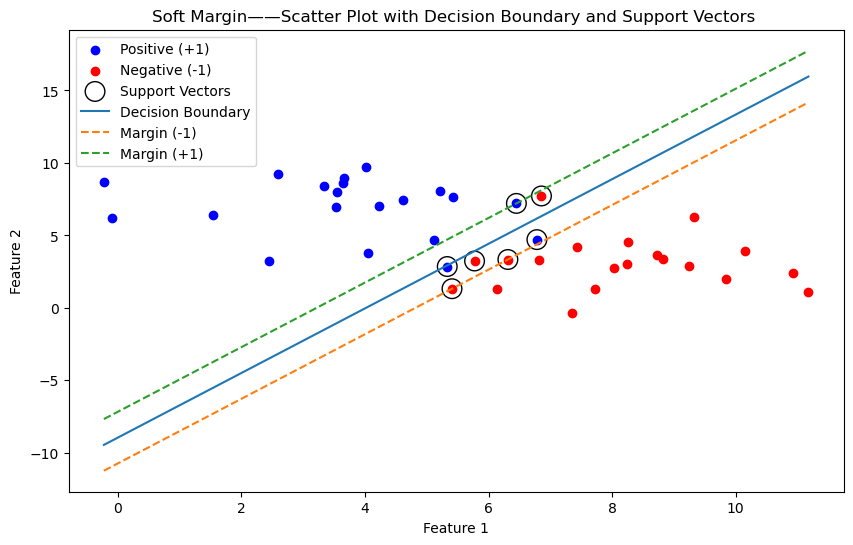

In [10]:
# ---- Your code here ----

# 将数据集按照标签进行划分 即正样本和负样本
positive_samples = dataset2[dataset2[:, -1] == 1]
negative_samples = dataset2[dataset2[:, -1] == -1]
X = dataset2[:, :-1]  # 属性值

plt.figure(figsize=(10, 6))
# 绘制正样本点
plt.scatter(positive_samples[:, 0], positive_samples[:, 1], color="blue", label="Positive (+1)")
# 绘制负样本点
plt.scatter(negative_samples[:, 0], negative_samples[:, 1], color="red", label="Negative (-1)")

# 识别支持向量
support_vectors_indices = np.where(lambda_star > 0)[0]
support_vectors = X[support_vectors_indices]
print("Soft Margin Support Vectors: num:{}".format(len(support_vectors)))
print(support_vectors)
# 标记支持向量
plt.scatter(
    support_vectors[:, 0],
    support_vectors[:, 1],
    s=200,
    facecolors="none",
    edgecolors="k",
    label="Support Vectors",
)

# 创建用于绘制边界的 x 范围
x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
# 绘制决策边界
y1 = (-b_star - w_star[0] * x_range) / w_star[1]
# 绘制间隔边界
y2 = (-1 - b_star - w_star[0] * x_range) / w_star[1]
y3 = (1 - b_star - w_star[0] * x_range) / w_star[1]
plt.plot(x_range, y1, label="Decision Boundary")
plt.plot(x_range, y2, "--", label="Margin (-1)")
plt.plot(x_range, y3, "--", label="Margin (+1)")

# 添加标注和图例
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Soft Margin——Scatter Plot with Decision Boundary and Support Vectors ")
plt.legend()
plt.show()

3.非线性支持向量机与核函数

[Raisin Dataset](https://www.kaggle.com/datasets/muratkokludataset/raisin-dataset)是一个葡萄干的数据集，总共有900个样本，每个样本包含7个(都是连续的)特征以及1个标签，每个标签只有两种可能取值。本次实验已经按照8：2的比例划分成了训练数据集'Raisin_train.csv'以及测试数据集'Raisin_test.csv'，且每个数据集都已经做了特征归一化处理以及把标签的值替换成了+1和-1。

<span style="color:purple">1) 读入训练数据集'Raisin_train.csv',把数据类型都转换成np.double类型。</span>

In [11]:
# ---- Your code here ----

# 读入训练数据集并转换成numpy数组格式 数据类型都转换成np.double格式
raisin_train = pd.read_csv("Raisin_train.csv")
raisin_train = np.array(raisin_train, dtype="double")
print(raisin_train)

[[ 0.11856393  0.09871008  0.19151796 ...  0.69963191  0.11955093
   1.        ]
 [ 0.16172316  0.14039884  0.22539187 ...  0.6778174   0.14777703
   1.        ]
 [ 0.22695035  0.25019883  0.20910105 ...  0.7643111   0.21275387
   1.        ]
 ...
 [ 0.78404355  0.45912437  0.7375704  ...  0.739582    0.48544436
  -1.        ]
 [ 0.29910446  0.20301683  0.41612836 ...  0.87157647  0.25033783
   1.        ]
 [ 0.24432023  0.21015588  0.29878912 ...  0.65918899  0.22401487
   1.        ]]


<span style="color:purple">2)  
求对偶问题的最优解$\lambda^*$  
在数据非线性可分的场景中，我们需要求解下面这个主问题。
\begin{align}
\min_{\pmb{\omega},b,\xi_i}\quad &\frac12 ||\pmb{\omega}||^2+C\times\sum_{i=1}^m \xi_i\\
s.t.\quad &y_i(\pmb{\omega}^T \phi(\pmb{x}_i)+b)\ge 1-\xi_i,i=1,...,m\\
&\xi_i\ge 0, i=1,...,m\\
\end{align}
</span>

<span style="color:purple">对应地，我们需要：  
选择一个核函数$K(\pmb{x},\pmb{z})$以及参数C，求解如下对偶问题（参考课件）：</span>
$$
\begin{align}
\min_\lambda\quad   &\frac{1}{2}\sum_{i=1}^m\sum_{j=1}^m\lambda_i\lambda_jy_iy_jK(\pmb{x}_i,\pmb{x}_j)-\sum_{i=1}^m\lambda_i \\
s.t. \quad  &\sum_{i=1}^m\lambda_iy_i=0 \\
      &0\leq \lambda_i \leq C, i=1,...,m 
\end{align}
$$

相较于硬间隔最大化的优化问题，该优化问题仅需要对矩阵$P$做改动。
从以下常用的核函数中选择一个作为该优化问题中的$K$（其中的参数请自行进行调整）：
* 线性核：$K(\pmb{x},\pmb{z})=\pmb{x}^T\pmb{z}$
* 多项式核：$K(\pmb{x},\pmb{z})=(\pmb{x}^T\pmb{z}+1)^p$
* 高斯核：$K(\pmb{x},\pmb{z})=exp(-\frac{\parallel \pmb{x}-\pmb{z} \parallel^2}{2\sigma^2})$
* 拉普拉斯核：$K(\pmb{x},\pmb{z})=exp(-\frac{\parallel \pmb{x}-\pmb{z} \parallel}{\sigma})$
* Sigmoid核：$K(\pmb{x},\pmb{z})=tanh(\beta\pmb{x}^T\pmb{z}+\theta)$

则$P是一个m\times m的矩阵，其中P_{ij}=y_iy_jK(\pmb{x_i},\pmb{x_j})$。

In [12]:
# ---- Your code here ----

# 定义高斯核函数
def gaussian_kernel(x, z, sigma=0.5):
    return np.exp(-np.sum((x - z) ** 2) / (2 * sigma**2))

def get_lambda_star(dataset,kernel_function,C=10):
    # 获取维度
    m, n = dataset.shape
    # 从数据集中获取属性列和标签列
    X = dataset[:, :-1]  # 属性值
    Y = dataset[:, -1].reshape(-1, 1)  # 标签
    # 初始化P矩阵
    P = np.zeros((m, m))
    # 计算高斯核的P矩阵
    for i in range(m):
        for j in range(m):
            kernel_value = kernel_function(X[i], X[j])  # 计算核函数值
            P[i, j] = Y[i] * Y[j] * kernel_value
    P = matrix(P)
    # q是一个m x 1的所有值都为-1的列向量
    q = matrix(-1.0, (m, 1))
    # 构建G矩阵
    G_top = np.eye(m) * -1  # 构造m x m的-1单位矩阵
    G_bottom = np.eye(m)  # 构造m x m的单位矩阵
    G = np.vstack((G_top, G_bottom))  # 进行上下拼接
    G = matrix(G)
    # 构建h向量
    h_top = np.zeros(m)
    h_bottom = np.ones(m) * C
    h = np.hstack((h_top, h_bottom))  # 进行拼接
    h = matrix(h.reshape(-1, 1))
    # A是标签列 需要转换成行形式
    A = matrix(dataset[:, -1]).T
    # b=[0] 标量
    b = matrix(0.0)
    # 送入函数中进行求解
    sol = solvers.qp(P, q, G, h, A, b, kktsolver="ldl")
    # 返回对偶函数的解lambda_star
    return sol["x"]


# 得到对偶问题的解lambda_star
lambda_star = get_lambda_star(raisin_train,gaussian_kernel)
print()
print("Kernel Trick")
print("对偶问题的解lambda_star:")
print(lambda_star)
print(type(lambda_star))

C:\Users\DELL\AppData\Local\Temp\ipykernel_35936\3012089619.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[i, j] = Y[i] * Y[j] * kernel_value


     pcost       dcost       gap    pres   dres
 0: -1.3100e+03 -3.5329e+04  6e+04  3e-01  5e-14
 1: -1.3498e+03 -6.7938e+03  6e+03  7e-03  7e-14
 2: -1.7456e+03 -3.3608e+03  2e+03  2e-03  6e-14
 3: -1.9243e+03 -2.9986e+03  1e+03  1e-03  6e-14
 4: -2.0361e+03 -2.7354e+03  7e+02  6e-04  6e-14
 5: -2.1021e+03 -2.5945e+03  5e+02  3e-04  6e-14
 6: -2.1648e+03 -2.4656e+03  3e+02  2e-04  6e-14
 7: -2.2088e+03 -2.3823e+03  2e+02  7e-05  6e-14
 8: -2.2330e+03 -2.3432e+03  1e+02  4e-05  6e-14
 9: -2.2588e+03 -2.3011e+03  4e+01  1e-05  7e-14
10: -2.2659e+03 -2.2884e+03  2e+01  3e-06  6e-14
11: -2.2722e+03 -2.2796e+03  7e+00  4e-07  7e-14
12: -2.2747e+03 -2.2766e+03  2e+00  1e-13  7e-14
13: -2.2755e+03 -2.2757e+03  1e-01  6e-14  7e-14
14: -2.2756e+03 -2.2756e+03  5e-03  2e-14  8e-14
15: -2.2756e+03 -2.2756e+03  5e-05  2e-14  8e-14
Optimal solution found.

Kernel Trick
对偶问题的解lambda_star:
[ 9.48e-08]
[ 6.90e-08]
[ 1.00e+01]
[ 7.53e+00]
[ 1.52e-07]
[ 1.34e-07]
[ 1.00e+01]
[ 1.44e-05]
[ 1.36e-07]
[ 4

<span style="color:purple">3)  
求出$b^*=y_j-\sum_{i=1}^m \lambda_i^*y_iK(\pmb{x_i},\pmb{x_j})$, 其中$j$为$\lambda^*$中的一个正分量$0<\lambda_j^*<C$的下标。</span>

In [13]:
# ---- Your code here ----
def get_b_star(dataset,kernel_function,lambda_star,threshold = 1e-4):
    # 此处lambda_star中的一个正分量的下标仍然选取其中最大的
    # 获取维度
    m, n = dataset.shape
    # 设置阈值对lambda_star进行筛选和最大值的获取
    # threshold = 1e-4  # 阈值
    max_lambda_star = 0  # 初始化最大分量进行比较
    max_index = None  # 初始化最大分量的索引
    for i in range(m):
        if lambda_star[i] < threshold:
            # 避免选择非常接近0的分量
            # lambda_star[i] = 0
            continue
        elif C - lambda_star[i] < threshold:
            # 避免选择非常接近C的分量
            continue
        elif lambda_star[i] > max_lambda_star and lambda_star[i] < C:  # 对lambda_star加上范围限制
            # 获取lambda_star中最大分量对应的索引
            max_lambda_star = lambda_star[i]
            max_index = i
    # 计算b_star
    X = dataset[:, :-1]  # 属性值xi
    Y = dataset[:, -1].reshape(-1, 1)  # 标签yi
    # 初始化
    b_star = Y[max_index].item()
    # 取lambda_star中最大的分量来计算b_star
    j = max_index
    for i in range(m):
        kernel_value = kernel_function(X[i], X[j])  # 使用前面定义的高斯核函数
        b_star = b_star - lambda_star[i] * Y[i] * kernel_value
    return b_star[0]
 
b_star = get_b_star(raisin_train,gaussian_kernel,lambda_star)
print("b_star:", b_star)

b_star: -0.6531580591271995


<span style="color:purple">4) 读入测试数据集'Raisin_test.csv',用分类决策函数$f(\pmb{x})=sign(\sum_{i=1}^m \lambda_i^*y_iK(\pmb{x}_i,\pmb{x})+b^*)$（注意这里的$m,\lambda_i^*,y_i,\pmb{x}_i$是训练集的, $\pmb{x}$是测试集的）进行预测，输出预测准确率。</span>

In [14]:
# ---- Your code here ----


# 线性核函数
def linear_kernel(x, z):
    return np.dot(x, z)


# 多项式核函数
def polynomial_kernel(x, z, p=3):
    return (np.dot(x, z) + 1) ** p


# 拉普拉斯核函数
def laplacian_kernel(x, z, sigma=0.5):
    return np.exp(-np.sum(x - z) / sigma)


# sigmoid核函数
def sigmoid_kernel(x, z, beta=1.0, theta=1e-5):
    return np.tanh(beta * np.dot(x, z) + theta)


# 读入测试数据集并转换成numpy数组格式 数据类型都转换成np.double格式
raisin_test = pd.read_csv("Raisin_test.csv")
raisin_test = np.array(raisin_test, dtype="double")
X_test = raisin_test[:, :-1]  # 获取测试集属性列
Y_test = raisin_test[:, -1].reshape(-1, 1)  # 获取测试集标签列
X = raisin_train[:, :-1]  # 训练集属性值xi
Y = raisin_train[:, -1].reshape(-1, 1)  # 训练集标签yi


# 定义分类决策函数
def decision_function(kernel_function, lambda_star, b_star, X_test=X_test, X_train=X, Y_train=Y):
    f_x = np.zeros(X_test.shape[0])
    # 对于测试集中的每个样本
    for j, x in enumerate(X_test):
        sum = 0
        # 遍历训练集中的全部样本
        # x是测试集的
        for i in range(X_train.shape[0]):
            sum += lambda_star[i] * Y_train[i] * kernel_function(X_train[i], x)
        # 存储当前测试集样本的预测值
        f_x[j] = sum + b_star
    # 调用np.sign进行决策分类
    return np.sign(f_x).reshape(-1, 1)


def get_accuracy(kernel_function, lambda_star, b_star, Y_test=Y_test):
    predictions = decision_function(kernel_function, lambda_star, b_star)
    accuracy = np.mean(predictions == Y_test)
    print("{}_预测准确率为: {:.4f}%".format(kernel_function.__name__, accuracy * 100))


gaussian_kernel_lambda_star = get_lambda_star(raisin_train, gaussian_kernel)
laplacian_kernel_lambda_star = get_lambda_star(raisin_train, laplacian_kernel)
linear_kernel_lambda_star = get_lambda_star(raisin_train, linear_kernel)
polynomial_kernel_lambda_star = get_lambda_star(raisin_train, polynomial_kernel)
sigmoid_kernel_lambda_star = get_lambda_star(raisin_train, sigmoid_kernel)


get_accuracy(
    gaussian_kernel,
    gaussian_kernel_lambda_star,
    get_b_star(raisin_train, gaussian_kernel, gaussian_kernel_lambda_star),
)
get_accuracy(
    laplacian_kernel,
    laplacian_kernel_lambda_star,
    get_b_star(raisin_train, laplacian_kernel, laplacian_kernel_lambda_star),
)
get_accuracy(
    linear_kernel,
    linear_kernel_lambda_star,
    get_b_star(raisin_train, linear_kernel, linear_kernel_lambda_star),
)
get_accuracy(
    polynomial_kernel,
    polynomial_kernel_lambda_star,
    get_b_star(raisin_train, polynomial_kernel, polynomial_kernel_lambda_star),
)
get_accuracy(
    sigmoid_kernel,
    sigmoid_kernel_lambda_star,
    get_b_star(raisin_train, sigmoid_kernel, sigmoid_kernel_lambda_star),
)

C:\Users\DELL\AppData\Local\Temp\ipykernel_35936\3012089619.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[i, j] = Y[i] * Y[j] * kernel_value


     pcost       dcost       gap    pres   dres
 0: -1.3100e+03 -3.5329e+04  6e+04  3e-01  5e-14
 1: -1.3498e+03 -6.7938e+03  6e+03  7e-03  7e-14
 2: -1.7456e+03 -3.3608e+03  2e+03  2e-03  6e-14
 3: -1.9243e+03 -2.9986e+03  1e+03  1e-03  6e-14
 4: -2.0361e+03 -2.7354e+03  7e+02  6e-04  6e-14
 5: -2.1021e+03 -2.5945e+03  5e+02  3e-04  6e-14
 6: -2.1648e+03 -2.4656e+03  3e+02  2e-04  6e-14
 7: -2.2088e+03 -2.3823e+03  2e+02  7e-05  6e-14
 8: -2.2330e+03 -2.3432e+03  1e+02  4e-05  6e-14
 9: -2.2588e+03 -2.3011e+03  4e+01  1e-05  7e-14
10: -2.2659e+03 -2.2884e+03  2e+01  3e-06  6e-14
11: -2.2722e+03 -2.2796e+03  7e+00  4e-07  7e-14
12: -2.2747e+03 -2.2766e+03  2e+00  1e-13  7e-14
13: -2.2755e+03 -2.2757e+03  1e-01  6e-14  7e-14
14: -2.2756e+03 -2.2756e+03  5e-03  2e-14  8e-14
15: -2.2756e+03 -2.2756e+03  5e-05  2e-14  8e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2918e+06 -3.4196e+06  6e+08  9e+01  1e-11
 1: -1.7133e+06 -3.0027e+06  6e+08  9e+01  1e-1

C:\Users\DELL\AppData\Local\Temp\ipykernel_35936\2303726356.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f_x[j] = sum + b_star


gaussian_kernel_预测准确率为: 82.7778%
laplacian_kernel_预测准确率为: 53.8889%
linear_kernel_预测准确率为: 87.2222%
polynomial_kernel_预测准确率为: 87.2222%
sigmoid_kernel_预测准确率为: 72.2222%


**<font color = blue size=4>第三部分:作业提交</font>**

一、实验课下课前提交完成代码，如果下课前未完成，请将已经完成的部分进行提交，未完成的部分于之后的实验报告中进行补充  
要求:  
1)文件格式为：学号-姓名.ipynb  
2)【不要】提交文件夹、压缩包、数据集等无关文件，只需提交单个ipynb文件即可，如果交错请到讲台前联系助教，删掉之前的错误版本后再进行提交

二、实验报告下周五实验课(12月1号 14:20)上课前提交报告  
要求：  
1)文件格式为：学号-姓名.pdf  
2)【不要】提交文件夹、压缩包、代码文件、数据集等任何与实验报告无关的文件，只需要提交单个pdf文件即可  
3)文件命名时不需要额外添加“实验几”等额外信息，按照格式提交  
4)每周的实验报告提交地址会变化，且有时间限制，提交时间为下周的实验课开始时，请注意及时提交。

实验十一(支持向量机)的实验报告上交地址:https://send2me.cn/TRRgKD4K/RX29mant_U152w

三、课堂课件获取地址:https://www.jianguoyun.com/p/DZKTh-IQp5WhChiIn6gFIAA  
实验内容获取地址:https://www.jianguoyun.com/p/DWOjj7kQp5WhChi0nqkFIAA